# Project

## Importing modules

In [1]:
!pip install torchinfo --quiet

In [2]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setting seed

In [3]:
# Set the seed for PyTorch
torch.manual_seed(1405)

# Set the seed for NumPy
np.random.seed(1405)

# Set the seed for Python's built-in random library
random.seed(1405)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(1405)
    torch.cuda.manual_seed_all(1405)  # if you are using multi-GPU.

# Generic functions

The functions and classes here are taken from lab 5 with all the junk removed. They (should) work for any dataset.

In [4]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [5]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [7]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # ChatGPT says opt.zero_grad should be first not last?
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [8]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

In [9]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Move input data to the same device as the model
            xb = xb.to(device)
            yb = yb.to(device)

            # Unpack the loss and other outputs
            loss, _ = loss_batch(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Move input data to the same device as the model
                xb = xb.to(device)
                yb = yb.to(device)

                # Get validation loss
                val_loss, _ = loss_batch(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss function
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Function that loads model if it exists otherwise trains

In [42]:
def load_or_train_model(model_path, epochs, model, loss_func, opt, train_dl, val_dl):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    try:
        # Load the pre-trained model
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        # Train the model if no saved model exists
        print(f"Model not found at {model_path}, starting training.")
        fit(epochs, model, loss_func, opt, train_dl, val_dl)
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

## Loading MNIST as example

In [11]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [12]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


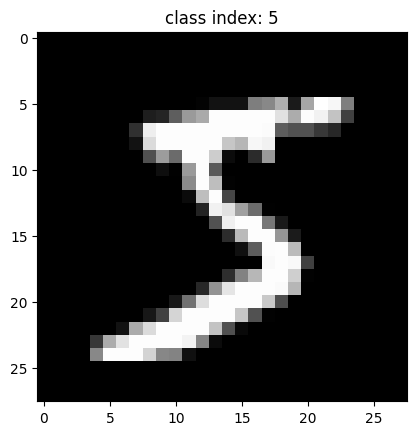

In [13]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

### Split data

DataLoader is used to efficiently iterate over the datasets during training. bs is the batch size, set to 64, dictating how many samples are processed at a time.

In [14]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

bs = 64  # batch size
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Preprocess the data to have shape (-1,1,28,28).

WrappedDataLoader applies the preprocess function to each batch of data.

In [15]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs) #forstår ikke denne. Vi har jo lige defineret train_dl og valid_dl??
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Model

Basic model with batchnormalization (as recommended in Training Convolutional Neural Networks - part 2)

In [16]:
MNIST_model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(10),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

### Train

In [17]:
MNIST_model.to(dev) #Makes device GPU if availbale else it is CPU
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = optim.SGD(MNIST_model.parameters(), lr=lr, momentum=0.9)

Epoch 1/2 - Train Loss: 1.0959, Train Acc: 0.7589 - Val Loss: 0.5552, Val Acc: 0.8889
Epoch 2/2 - Train Loss: 0.4971, Train Acc: 0.9038 - Val Loss: 0.3655, Val Acc: 0.9179


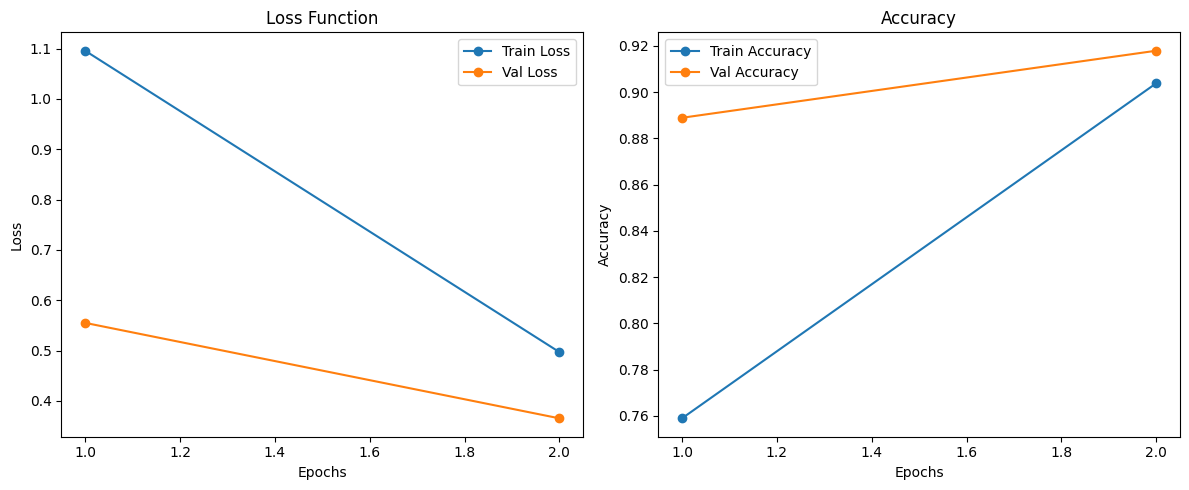

In [18]:
fit(epochs, MNIST_model, loss_func, opt, train_dl, valid_dl)

# Loading German traffic signs

In [19]:
# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'train', 'test', 'Train', 'meta', 'Meta']


**Define transformation and load into train, test and valdiadation set.**

Note that the test files the classes are hidden. So we just take train files and randomly split into train, test and validation set. Can be confirmed by running this code



```
# Check the contents of the train and test folders
train_files = os.listdir('/content/gtsrb/train')
test_files = os.listdir('/content/gtsrb/test')
print("Train folders:", train_files)
print("Test folders:", test_files)
```



In [79]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the dataset and transform
full_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Check the total number of samples in the dataset
total_samples = len(full_dataset)
print(f"Total samples in the dataset: {total_samples}")

# Get the first image and its label from the dataset
image, label = full_dataset[0]

# Check the shape of the image tensor
print(f"Shape of the first image: {image.shape}")
print(f"Label of the first image: {label}")

Total samples in the dataset: 39209
Shape of the first image: torch.Size([3, 160, 160])
Label of the first image: 0


Now we split this into 70% train, 15% validation and 15% test.

In [80]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths for each split
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 27446, Validation size: 5881, Test size: 5882


In [81]:
# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [82]:
# Set the batch size
bs = 64

# Create DataLoaders. A dataloader provides an efficient way to iterate over your dataset during training
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs * 2, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs * 2, shuffle=False)

## Dataset summary

Show how many classes we have in dataset:

In [24]:
# Get the number of classes from the original dataset (full_dataset)
num_classes = len(full_dataset.classes)

# Print the number of classes
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 43


43 classes

## Visualize the classes

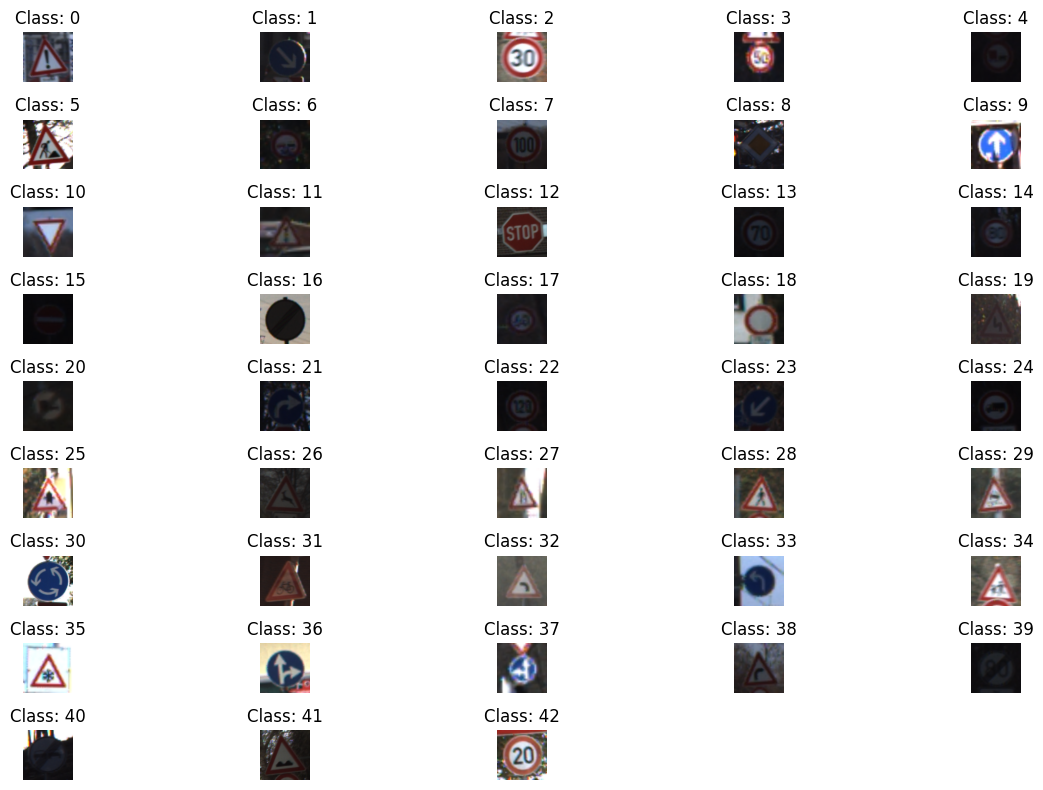

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Function to show images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Undo normalization
    img = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format
    plt.axis('off')  # Hide axis

# Create a dictionary to keep track of images displayed for each class
class_count = {i: 0 for i in range(num_classes)}

# Store images and labels
ordered_images = []
ordered_labels = []

# Get images until one for each class is found
while len(ordered_images) < num_classes:
    dataiter = iter(train_dl)  # Reset the iterator for each pass
    images, labels = next(dataiter)

    # Loop through the images to find and store one per class
    for i in range(len(images)):
        label = labels[i].item()

        # Check if we have already stored an image for this class
        if class_count[label] < 1:  # Change to images_per_class if needed
            ordered_images.append(images[i])  # Store the image
            ordered_labels.append(label)  # Store the label
            class_count[label] += 1  # Increment count for this class

# Plot the images and their corresponding labels in order
ordered_labels = np.sort(ordered_labels)
plt.figure(figsize=(12, 8))
num_images_per_row = 5  # Maximum images per row

# Loop to display images in order
for i, (img, label) in enumerate(zip(ordered_images, ordered_labels)):
    plt.subplot((num_classes + num_images_per_row - 1) // num_images_per_row, num_images_per_row, i + 1)
    imshow(img)
    plt.title(f'Class: {label}')

plt.tight_layout()
plt.show()

## Baseline model

In [26]:
baseline_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),#Used to flatten he output
    #nn.Flatten(), # Flatten the output for the linear layer
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



In [27]:
summary(baseline_model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─ReLU: 1-2                              [1, 16, 80, 80]           --
├─Conv2d: 1-3                            [1, 32, 40, 40]           4,640
├─ReLU: 1-4                              [1, 32, 40, 40]           --
├─Conv2d: 1-5                            [1, 64, 20, 20]           18,496
├─ReLU: 1-6                              [1, 64, 20, 20]           --
├─AdaptiveAvgPool2d: 1-7                 [1, 64, 1, 1]             --
├─Lambda: 1-8                            [1, 64]                   --
├─Linear: 1-9                            [1, 43]                   2,795
Total params: 26,379
Trainable params: 26,379
Non-trainable params: 0
Total mult-adds (M): 17.69
Input size (MB): 0.31
Forward/backward pass size (MB): 1.43
Params size (MB): 0.11
Estimated Total Size (MB): 1.85

### Train baseline model

In [28]:
baseline_model.to(dev)
lr = 0.01
epochs = 3
loss_func = F.cross_entropy
opt = torch.optim.Adam(baseline_model.parameters(), lr=lr) # Adam optimizer

The output is the loss.

Increase speed so only use 25%.

In [29]:
# Grab 25% of the data
#subset_indices = random.sample(range(len(train_dataset)), int(0.25 * len(train_dataset)))
#subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
#train_dl = DataLoader(train_dataset, batch_size=bs, sampler=subset_sampler)

Epoch 1/3 - Train Loss: 3.0734, Train Acc: 0.1558 - Val Loss: 2.8418, Val Acc: 0.2064
Epoch 2/3 - Train Loss: 2.9637, Train Acc: 0.1817 - Val Loss: 2.9600, Val Acc: 0.1787
Epoch 3/3 - Train Loss: 2.7011, Train Acc: 0.2391 - Val Loss: 2.4274, Val Acc: 0.2957


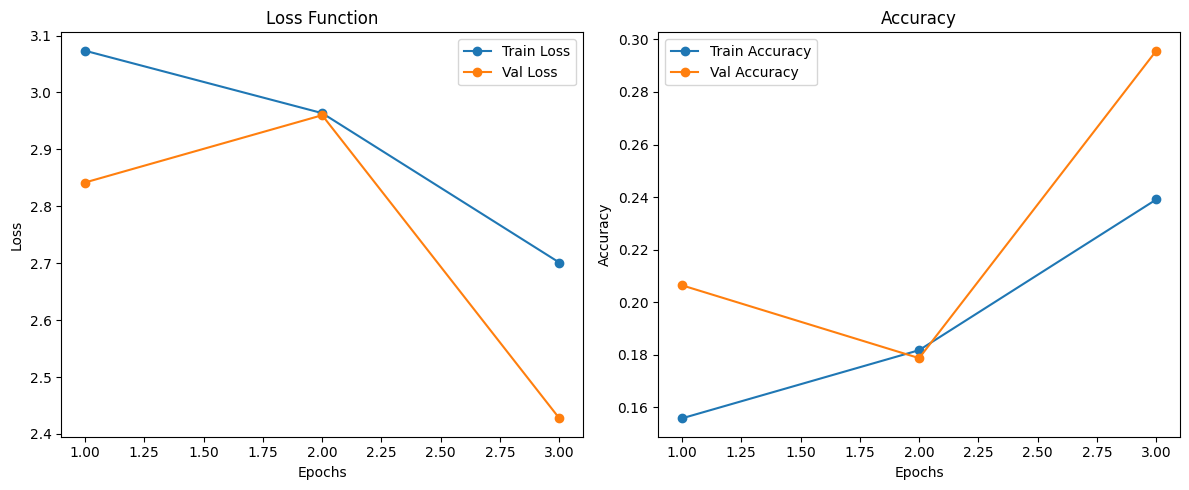

In [30]:
fit(epochs, baseline_model, loss_func, opt, train_dl, val_dl)

### Visualize some predictions

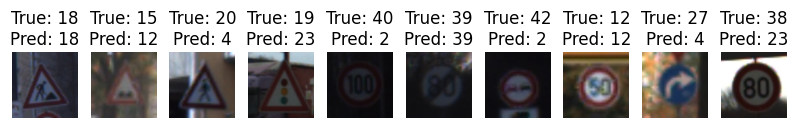

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Lambda()
  (8): Linear(in_features=64, out_features=43, bias=True)
)

In [31]:
def denormalize(img):
    img = img / 2 + 0.5  # assuming the images were normalized to [-1, 1]
    return img.clamp(0, 1)  # clamp values to [0, 1]

# Modified show_images function with denormalization
def show_images(images, labels, preds, num_images=10):
    images = denormalize(images)  # Denormalize before displaying
    plt.figure(figsize=(10, 10))

    # Limit to the specified number of images (default is 5)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
        plt.title(f'True: {labels[i]}\nPred: {preds[i]}')
        plt.axis('off')
    plt.show()

# Get a batch of validation images
baseline_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = baseline_model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# Revert model back to training mode
baseline_model.train()

## Data augmentation

Consider adding some data augmentation

## Better model (batch normalization, dropout, bigger model)

In [32]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Dropout applied here for the dense layer

    nn.Linear(128, num_classes)
)

In [33]:
summary(model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─BatchNorm2d: 1-2                       [1, 16, 80, 80]           32
├─ReLU: 1-3                              [1, 16, 80, 80]           --
├─Conv2d: 1-4                            [1, 32, 40, 40]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 40, 40]           64
├─ReLU: 1-6                              [1, 32, 40, 40]           --
├─Conv2d: 1-7                            [1, 64, 20, 20]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 20, 20]           128
├─ReLU: 1-9                              [1, 64, 20, 20]           --
├─Conv2d: 1-10                           [1, 128, 10, 10]          73,856
├─BatchNorm2d: 1-11                      [1, 128, 10, 10]          256
├─ReLU: 1-12                             [1, 128, 10, 10]          --
├



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



### Train model

In [34]:
model.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

Epoch 1/15 - Train Loss: 2.9298, Train Acc: 0.1746 - Val Loss: 2.2714, Val Acc: 0.2920
Epoch 2/15 - Train Loss: 1.9741, Train Acc: 0.3780 - Val Loss: 1.6146, Val Acc: 0.4477
Epoch 3/15 - Train Loss: 1.5372, Train Acc: 0.5007 - Val Loss: 1.1633, Val Acc: 0.6176
Epoch 4/15 - Train Loss: 1.0670, Train Acc: 0.6633 - Val Loss: 0.5924, Val Acc: 0.8038
Epoch 5/15 - Train Loss: 0.7110, Train Acc: 0.7841 - Val Loss: 0.3453, Val Acc: 0.8939
Epoch 6/15 - Train Loss: 0.5263, Train Acc: 0.8390 - Val Loss: 0.6040, Val Acc: 0.8582
Epoch 7/15 - Train Loss: 0.4079, Train Acc: 0.8783 - Val Loss: 0.1877, Val Acc: 0.9471
Epoch 8/15 - Train Loss: 0.3366, Train Acc: 0.8991 - Val Loss: 0.1567, Val Acc: 0.9585
Epoch 9/15 - Train Loss: 0.2884, Train Acc: 0.9105 - Val Loss: 0.1173, Val Acc: 0.9701
Epoch 10/15 - Train Loss: 0.2568, Train Acc: 0.9214 - Val Loss: 0.1805, Val Acc: 0.9536
Epoch 11/15 - Train Loss: 0.2318, Train Acc: 0.9315 - Val Loss: 0.1056, Val Acc: 0.9713
Epoch 12/15 - Train Loss: 0.2051, Train A

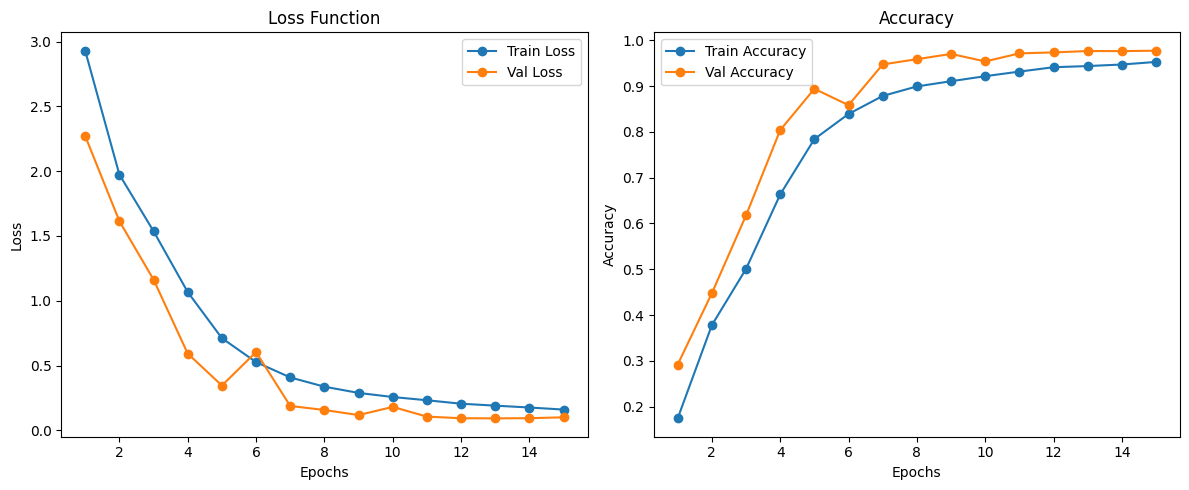

In [35]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model.pth'
load_or_train_model(path_model, epochs, model, loss_func, opt, train_dl, val_dl)

# fit(epochs, model, loss_func, opt, train_dl, val_dl)

Clearly not done training.... Can just continue trainning by recalling fit like this (it remembers the weights it has learned from the training above).

```
fit(epochs, model, loss_func, opt, train_dl, val_dl)
```



Training 15 epochs more and lowering the lr:

In [36]:
model.to(dev)
lr = 0.005
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

Loaded model above, but otherwise run this maybe

Epoch 1/15 - Train Loss: 0.1193, Train Acc: 0.9617 - Val Loss: 0.0762, Val Acc: 0.9849
Epoch 2/15 - Train Loss: 0.1136, Train Acc: 0.9655 - Val Loss: 0.0761, Val Acc: 0.9854
Epoch 3/15 - Train Loss: 0.1048, Train Acc: 0.9677 - Val Loss: 0.0785, Val Acc: 0.9820
Epoch 4/15 - Train Loss: 0.0954, Train Acc: 0.9676 - Val Loss: 0.0788, Val Acc: 0.9849
Epoch 5/15 - Train Loss: 0.0957, Train Acc: 0.9706 - Val Loss: 0.0771, Val Acc: 0.9833
Epoch 6/15 - Train Loss: 0.0863, Train Acc: 0.9748 - Val Loss: 0.0772, Val Acc: 0.9857
Epoch 7/15 - Train Loss: 0.0731, Train Acc: 0.9754 - Val Loss: 0.0749, Val Acc: 0.9876
Epoch 8/15 - Train Loss: 0.0764, Train Acc: 0.9769 - Val Loss: 0.0698, Val Acc: 0.9859
Epoch 9/15 - Train Loss: 0.0716, Train Acc: 0.9778 - Val Loss: 0.0828, Val Acc: 0.9867
Epoch 10/15 - Train Loss: 0.0694, Train Acc: 0.9791 - Val Loss: 0.0762, Val Acc: 0.9838
Epoch 11/15 - Train Loss: 0.0697, Train Acc: 0.9803 - Val Loss: 0.0703, Val Acc: 0.9869
Epoch 12/15 - Train Loss: 0.0631, Train A

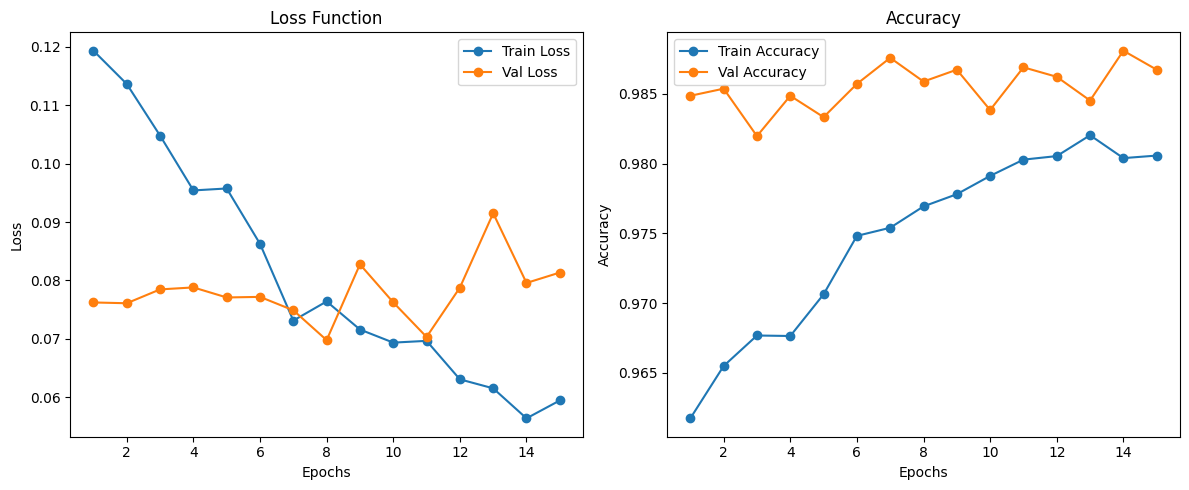

In [37]:
# fit(epochs, model, loss_func, opt, train_dl, val_dl)

#### Saving and loading the model

We should consider saving and loading the model instead of training to save time:


```
# Save in google drive:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model.pth')

# Load saved model
model.load_state_dict(torch.load('/content/gdrive/MyDrive/German-traffic-signs/model.pth'))
```



In [38]:
# Save in google drive:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model.pth')

### Visualize some predictions

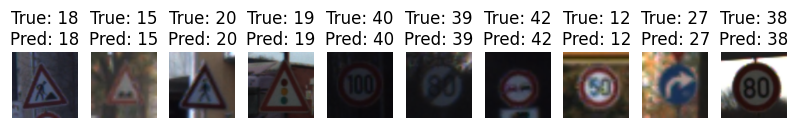

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_size=1)
  (16): Lambda()
  (17): Linear(in_features=256, out_features=128, b

In [39]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# revert model back to train mode
model.train()

## Transfer learning

We use the ResNet50 pre-trained on ImageNet for transfer learning

In [49]:
from torchvision import models

# Load ResNet50 pre-trained on ImageNet
model_transfer = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
model_transfer.to(dev)
lr = 0.01
epochs = 5
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_transfer.parameters(), lr=lr) # Adam optimizer

<ipython-input-42-ae35102575a7>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at test, starting training.
Epoch 1/5 - Train Loss: 1.5014, Train Acc: 0.7263 - Val Loss: 1.1155, Val Acc: 0.7596
Epoch 2/5 - Train Loss: 1.1259, Train Acc: 0.8124 - Val Loss: 1.0671, Val Acc: 0.7832
Epoch 3/5 - Train Loss: 0.9945, Train Acc: 0.8418 - Val Loss: 1.2180, Val Acc: 0.7948
Epoch 4/5 - Train Loss: 0.9456, Train Acc: 0.8594 - Val Loss: 1.0517, Val Acc: 0.8215
Epoch 5/5 - Train Loss: 0.8902, Train Acc: 0.8698 - Val Loss: 0.8944, Val Acc: 0.8568


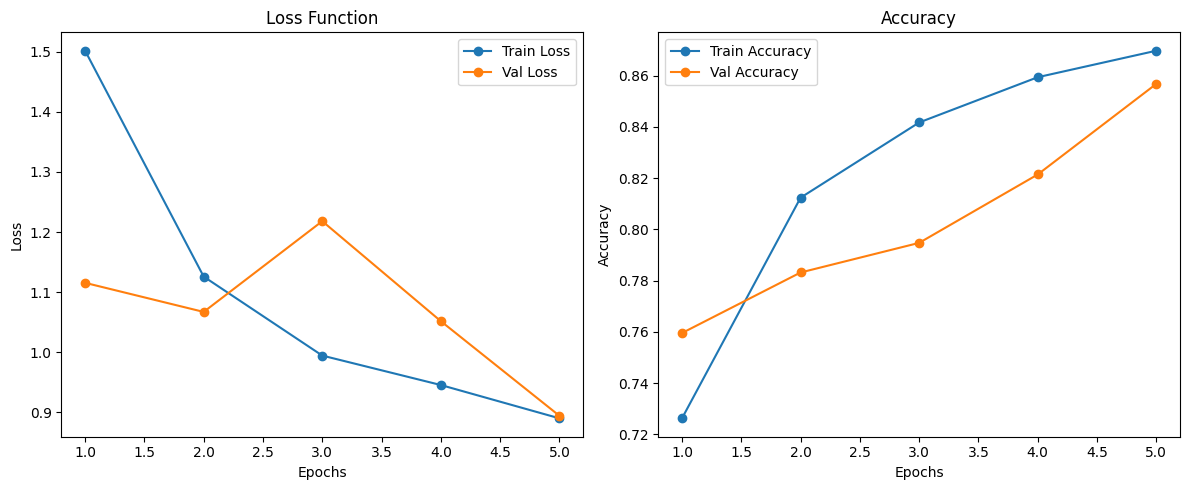

Model saved to test


In [54]:
transfer_model_path = '/content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth'
load_or_train_model(
    transfer_model_path,
    epochs, model_transfer,
    loss_func,
    opt,
    train_dl,
    val_dl
)

In [55]:
# Save in google drive:
torch.save(model_transfer.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model_transfer.pth')

# Bayesian CNN



We will now also train a bayesian CNN. We will (for now) do it by doing Bayes by Backprop (BBB)

## Bayes by Backprop (BBB)

See chapter 5 in Enhancing deep learning with bayesian inference. Code for the example is given here: https://github.com/PacktPublishing/Enhancing-Deep-Learning-with-Bayesian-Inference/tree/main/ch05/bbb

(Maybe a library already exists so less code needed?)

#### Using torchbnn

##### 1st attempt

In [56]:
!pip install torchbnn --quiet

In [57]:
import torchbnn as bnn

In [60]:
class BayesianCNN(nn.Module):
    def __init__(self, num_classes):
        super(BayesianCNN, self).__init__()

        prior_mu = 0
        prior_sigma = 1
        self.conv1 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 3, 16, kernel_size=3, stride=2, padding=1
        )
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 16, 32, kernel_size=3, stride=2, padding=1
        )
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 32, 64, kernel_size=3, stride=2, padding=1
        )
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 64, 128, kernel_size=3, stride=2, padding=1
        )
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 128, 256, kernel_size=3, stride=2, padding=1
        )
        self.bn5 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = bnn.BayesLinear(prior_mu, prior_sigma, 256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = bnn.BayesLinear(prior_mu, prior_sigma, 128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_bnn = BayesianCNN(num_classes=num_classes).to(dev)

Modifying loss_batch and fit function slightly to do bayesian neural networks.

In [61]:
def loss_batch_bnn(model, loss_func, xb, yb, opt=None):
    # Forward pass
    preds = model(xb)
    loss = loss_func(preds, yb)

    # Add KL Divergence for Bayesian layers
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl = kl_loss(model)

    # Total loss: cross-entropy + KL divergence
    total_loss = loss + 0.1 * kl  # 0.1 as the weight for KL divergence

    if opt is not None:
        total_loss.backward()
        opt.step()
        opt.zero_grad()

    return total_loss.item(), len(xb)

In [62]:
def fit_bnn(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Move input data to the same device as the model
            xb = xb.to(device)
            yb = yb.to(device)

            # Unpack the loss and other outputs
            loss, _ = loss_batch_bnn(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Move input data to the same device as the model
                xb = xb.to(device)
                yb = yb.to(device)

                # Get validation loss
                val_loss, _ = loss_batch_bnn(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [63]:
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

Epoch 1/2 - Train Loss: 141.3070, Train Acc: 0.0263 - Val Loss: 398.4661, Val Acc: 0.0275
Epoch 2/2 - Train Loss: 142.5118, Train Acc: 0.0246 - Val Loss: 407.2569, Val Acc: 0.0230


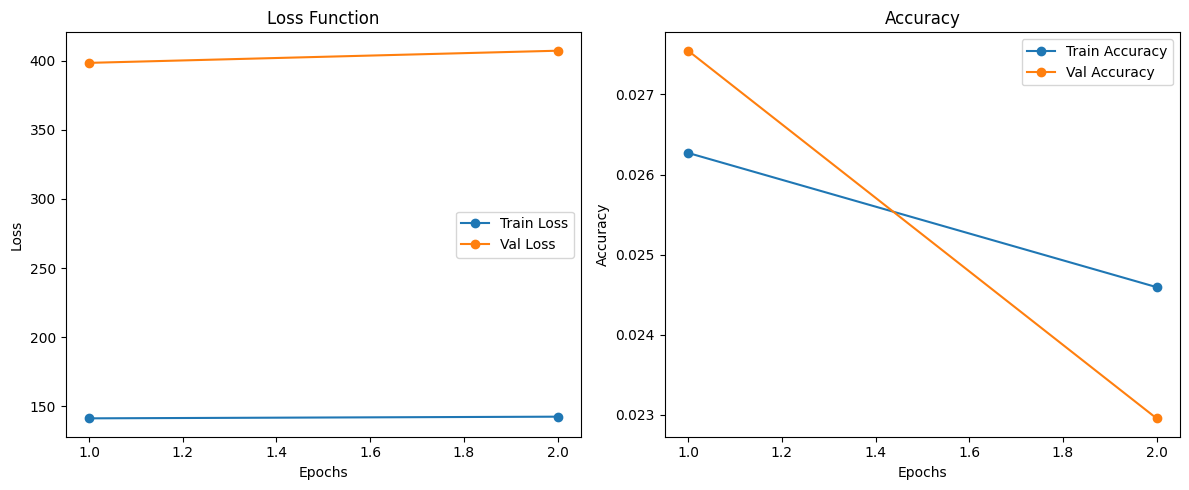

In [65]:
fit_bnn(epochs, model_bnn, loss_func, opt, train_dl, val_dl)

In [ ]:
torch.save(model_bnn.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth')



```
# Load saved model
model_bnn.load_state_dict(torch.load('/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth'))
```



##### 2nd attempt

In [67]:
model_bnn_2 = nn.Sequential(
    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=3 * 160 * 160,
        out_features=100
    ),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=43),
)

In [68]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model_bnn_2.parameters(), lr=0.01)

In [69]:
# Training loop
for step, (x, y) in enumerate(train_dl):
    x = x.view(x.size(0), -1)  # Flatten the input tensor

    pre = model_bnn_2(x)       # Forward pass
    ce = ce_loss(pre, y)       # Compute cross-entropy loss
    kl = kl_loss(model_bnn_2)  # Compute KL divergence loss
    cost = ce + kl_weight * kl  # Total cost

    optimizer.zero_grad()      # Zero out the gradients
    cost.backward()            # Backpropagate
    optimizer.step()           # Update weights

    # Calculate and print accuracy
    _, predicted = torch.max(pre.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    print(f'- Step {step}, Accuracy: {100 * correct / total:.2f} %')
    print(f'- CE Loss: {ce.item():.2f}, KL Loss: {kl.item():.2f}')

- Step 0, Accuracy: 3.12 %
- CE Loss: 28.24, KL Loss: 0.00
- Step 1, Accuracy: 3.12 %
- CE Loss: 318.79, KL Loss: 0.01
- Step 2, Accuracy: 6.25 %
- CE Loss: 729.08, KL Loss: 0.01
- Step 3, Accuracy: 6.25 %
- CE Loss: 791.40, KL Loss: 0.02
- Step 4, Accuracy: 6.25 %
- CE Loss: 564.98, KL Loss: 0.02
- Step 5, Accuracy: 3.12 %
- CE Loss: 681.34, KL Loss: 0.02
- Step 6, Accuracy: 3.12 %
- CE Loss: 686.37, KL Loss: 0.03
- Step 7, Accuracy: 1.56 %
- CE Loss: 774.24, KL Loss: 0.03
- Step 8, Accuracy: 1.56 %
- CE Loss: 918.24, KL Loss: 0.03
- Step 9, Accuracy: 1.56 %
- CE Loss: 807.96, KL Loss: 0.04
- Step 10, Accuracy: 1.56 %
- CE Loss: 804.41, KL Loss: 0.04
- Step 11, Accuracy: 4.69 %
- CE Loss: 937.55, KL Loss: 0.04
- Step 12, Accuracy: 4.69 %
- CE Loss: 861.14, KL Loss: 0.04
- Step 13, Accuracy: 3.12 %
- CE Loss: 797.86, KL Loss: 0.04
- Step 14, Accuracy: 3.12 %
- CE Loss: 685.09, KL Loss: 0.04
- Step 15, Accuracy: 1.56 %
- CE Loss: 610.60, KL Loss: 0.05
- Step 16, Accuracy: 0.00 %
- CE Lo

##### 3rd attempt

Same model as the non-bayesian one, but making the linear layers of our model bayesian.

In [111]:
model_bnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),  # Global pooling to reduce spatial dimensions

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor

    # Replace the deterministic Linear layers with Bayesian Linear layers
    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=256,
        out_features=128
    ),
    nn.ReLU(),
    nn.Dropout(0.3),

    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=128,
        out_features=num_classes
    )
)

Almost same function as fit, but just modifed for the bayesian setup.

In [72]:
def fit_bnn(epochs, model, ce_loss_func, kl_loss_func, kl_weight, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            # Clear gradients
            opt.zero_grad()

            # Forward pass through the model
            preds = model(xb)

            # Cross-entropy loss
            ce_loss = ce_loss_func(preds, yb)

            # KL divergence loss
            kl_loss = kl_loss_func(model)

            # Total loss: CE loss + weighted KL loss
            total_loss_value = ce_loss + kl_weight * kl_loss

            # Backpropagation
            total_loss_value.backward()

            # Update model weights
            opt.step()

            # Accumulate loss and accuracy
            total_loss += total_loss_value.item()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        val_loss_total, val_correct = 0.0, 0
        val_samples = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb = xb.to(device)
                yb = yb.to(device)

                # Forward pass
                preds = model(xb)

                # Compute validation loss
                ce_loss = ce_loss_func(preds, yb)
                kl_loss = kl_loss_func(model)
                total_loss_value = ce_loss + kl_weight * kl_loss

                val_loss_total += total_loss_value.item()
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_samples += yb.size(0)

        # Calculate average validation loss and accuracy
        val_loss_avg = val_loss_total / len(valid_dl)
        val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss and accuracy over epochs
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10 - Train Loss: 2.4390, Train Acc: 0.2566 - Val Loss: 1.7777, Val Acc: 0.4152
Epoch 2/10 - Train Loss: 1.6299, Train Acc: 0.4648 - Val Loss: 1.5304, Val Acc: 0.5130
Epoch 3/10 - Train Loss: 0.9484, Train Acc: 0.6959 - Val Loss: 1.2432, Val Acc: 0.7176
Epoch 4/10 - Train Loss: 0.4767, Train Acc: 0.8646 - Val Loss: 0.3646, Val Acc: 0.9068
Epoch 5/10 - Train Loss: 0.2918, Train Acc: 0.9281 - Val Loss: 0.1931, Val Acc: 0.9589
Epoch 6/10 - Train Loss: 0.2018, Train Acc: 0.9564 - Val Loss: 0.1606, Val Acc: 0.9713
Epoch 7/10 - Train Loss: 0.1652, Train Acc: 0.9690 - Val Loss: 0.1568, Val Acc: 0.9742
Epoch 8/10 - Train Loss: 0.1451, Train Acc: 0.9740 - Val Loss: 0.1853, Val Acc: 0.9648
Epoch 9/10 - Train Loss: 0.1338, Train Acc: 0.9778 - Val Loss: 0.2383, Val Acc: 0.9509
Epoch 10/10 - Train Loss: 0.1245, Train Acc: 0.9819 - Val Loss: 0.1423, Val Acc: 0.9752


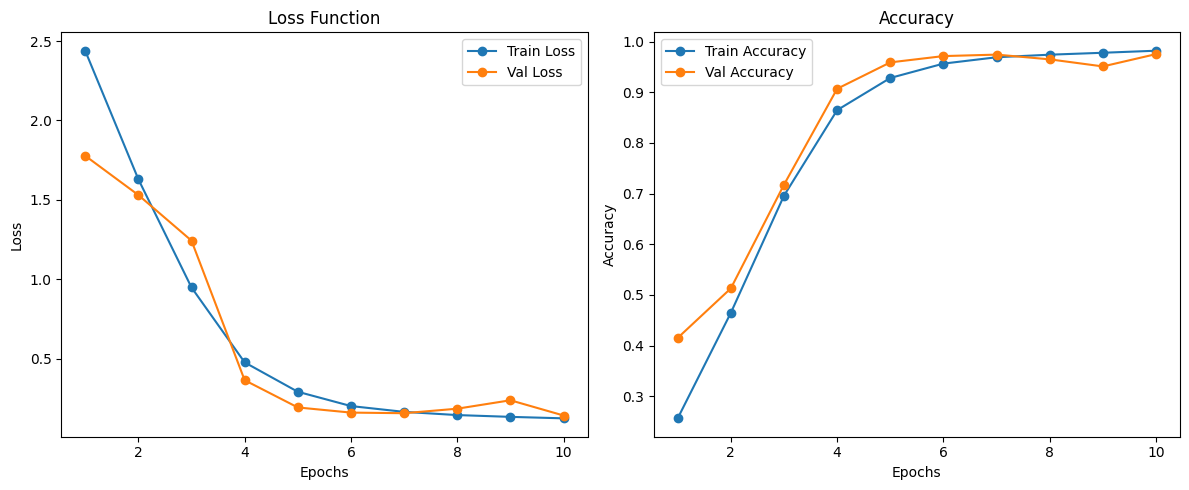

In [73]:
# Cross-entropy loss
ce_loss_func = nn.CrossEntropyLoss()

# KL divergence loss for Bayesian layers
kl_loss_func = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# Optimizer
opt = optim.Adam(model_bnn.parameters(), lr=0.01)

# Train the Bayesian CNN
fit_bnn(epochs=10, model=model_bnn, ce_loss_func=ce_loss_func, kl_loss_func=kl_loss_func,
        kl_weight=0.01, opt=opt, train_dl=train_dl, valid_dl=val_dl)

In [74]:
torch.save(model_bnn.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth')

###### Prediction/inference

Input image shape: torch.Size([1, 3, 160, 160])
True label: 34
Sample 0: 
  1. Class: 34, Probability: 0.9982
  2. Class: 1, Probability: 0.0015
  3. Class: 0, Probability: 0.0002
  4. Class: 40, Probability: 0.0000
  5. Class: 38, Probability: 0.0000
Sample 1: 
  1. Class: 34, Probability: 0.9971
  2. Class: 1, Probability: 0.0025
  3. Class: 0, Probability: 0.0004
  4. Class: 40, Probability: 0.0000
  5. Class: 38, Probability: 0.0000
Sample 2: 
  1. Class: 34, Probability: 0.9983
  2. Class: 1, Probability: 0.0014
  3. Class: 0, Probability: 0.0002
  4. Class: 40, Probability: 0.0000
  5. Class: 38, Probability: 0.0000
Sample 3: 
  1. Class: 34, Probability: 0.9994
  2. Class: 1, Probability: 0.0005
  3. Class: 0, Probability: 0.0001
  4. Class: 40, Probability: 0.0000
  5. Class: 38, Probability: 0.0000
Sample 4: 
  1. Class: 34, Probability: 0.9979
  2. Class: 1, Probability: 0.0019
  3. Class: 0, Probability: 0.0002
  4. Class: 40, Probability: 0.0000
  5. Class: 38, Probability:

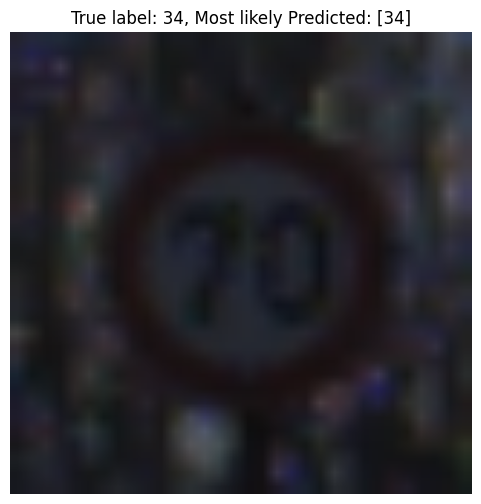

In [110]:
def sample_and_predict(model, image, num_samples=10):
    predictions = []

    for _ in range(num_samples):
        # Sample from the posterior weights
        with torch.no_grad():
            pred = model(image)  # Forward pass to get the prediction
            predictions.append(pred)

    # Convert predictions to a tensor for easier processing
    predictions = torch.stack(predictions)

    # Get the class predictions by taking the mode across the samples
    preds_classes = predictions.argmax(dim=2).mode(dim=0).values

    # Get probabilities of each class for the last layer
    probabilities = torch.softmax(predictions, dim=2)

    return preds_classes, probabilities

# Modified function to visualize predictions with sampling
def show_random_predictions(model, valid_dl, num_samples=10):
    model.eval()  # Set the model to evaluation mode

    # Get a random batch from the validation data loader
    for xb, yb in valid_dl:
        # Randomly select an index from the batch
        random_index = random.randint(0, len(xb) - 1)
        image = xb[random_index].unsqueeze(0)  # Add batch dimension
        true_label = yb[random_index].item()

        # Send the image to the device
        image = image.to(dev)

        # Check the shape of the input image
        print(f"Input image shape: {image.shape}")  # Debugging statement

        # Sample predictions
        preds_classes, probabilities = sample_and_predict(model, image, num_samples)

        # Denormalize the image for display
        denormalized_image = denormalize(image.squeeze().cpu())

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(denormalized_image.permute(1, 2, 0).numpy())  # Convert from CxHxW to HxWxC
        plt.title(f"True label: {true_label}, Most likely Predicted: {preds_classes.cpu().numpy()}")
        plt.axis('off')

        # Print predictions for each sample and probabilities
        print(f"True label: {true_label}")
        for i in range(num_samples):
            top_probs, top_classes = torch.topk(probabilities[i], k=5)  # Get top 5 classes and their probabilities
            top_probs = top_probs.cpu().numpy()
            top_classes = top_classes.cpu().numpy()
            #print(f"Top Classes and Probabilities: {[(top_classes[j], top_probs[j]) for j in range(len(top_probs))]}")

            print(f"Sample {i}: ")
            for i, (class_idx, prob) in enumerate(zip(top_classes[0], top_probs[0])):
              print(f"  {i+1}. Class: {class_idx}, Probability: {prob:.4f}")

        plt.show()  # Show the image
        break  # Exit after showing one image

# Call the function to show predictions for a random image
show_random_predictions(model_bnn, train_dl, num_samples=10)

# Adversiaral attack and/or out of distribution data

We in this section want to compare robustness of our CNN and bayesian our CNN against adversiaral attacks and/or out of distribtuion (OOD) data.

## Out of distribution data

Here we want to check what happens if we give our model for example a sign it hasn't seen before.

We want in the ideal case our CNN model to give same prob for each class, since it should reflect the uncertainty it has.

For the bayesian CNN we also want it for each sample of the posterior to give many different classes since it should be unsure about what this sign is.

## Adversiaral attack

Here we want to see how robust our models are if we make some
changes to the signs (think a damaged sign).